### Training Scripts

In [6]:
%load_ext autoreload
%aimport dataset
%aimport model
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from pathlib import Path
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from model import MyModel
from dataset import MyDataset
from utils import write_pickle

##### Dataset Initialization

In [4]:
with open("dataset/features/labels.txt", "rb") as f:
    labels = []
    for line in f:
        labels.append(line.decode("utf-8").strip())

print(labels)

['metal', 'pop', 'reggae', 'rock']


In [5]:
batch_size = 8

train_ds = MyDataset(
    root_dir=Path("dataset/features"),
    split="train",
)
test_ds = MyDataset(
    root_dir=Path("dataset/features"),
    split="test",
)
val_ds = MyDataset(
    root_dir=Path("dataset/features"),
    split="val",
)
train_loader = train_ds.get_loader(batch_size=batch_size, shuffle=True)
test_loader = test_ds.get_loader(batch_size=batch_size, shuffle=True)
val_loader = val_ds.get_loader(batch_size=batch_size, shuffle=True)

print(f"Train size: {len(train_ds)}")
print(f"Test size: {len(test_ds)}")
print(f"Val size: {len(val_ds)}")

Train size: 96
Test size: 12
Val size: 12


##### Model Initialization

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Process on {device}', end='\n\n')

# Training Metadata
epochs = 2
learning_rate = 0.001
lowest_val_loss = 1e10
best_val_epoch = 0
patience = 5
patience_counter = 0
best_model = None

# Training History
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Test Results
predictions = []
ground_truth = []

model = MyModel(output_classes=len(labels))
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Process on cpu



In [7]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    epoch_loss_train_ = []
    epoch_acc_train_ = 0
    epoch_data_len_ = 0

    model.train()
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        x, y = batch
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss_train_.append(loss.item())
        epoch_acc_train_ += (y_pred.argmax(1) == y.argmax(1)).sum().item()
        epoch_data_len_ += len(y)
    epoch_loss_train_ = np.mean(epoch_loss_train_)
    epoch_acc_train_ = epoch_acc_train_ / epoch_data_len_
    
    model.eval()
    with torch.no_grad():
        epoch_loss_val_ = []
        epoch_acc_val_ = 0
        epoch_data_len_ = 0
        for i, batch in enumerate(val_loader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_function(y_pred, y)

            epoch_loss_val_.append(loss.item())
            epoch_acc_val_ += (y_pred.argmax(1) == y.argmax(1)).sum().item()
            epoch_data_len_ += len(y)
    epoch_loss_val_ = np.mean(epoch_loss_val_)
    epoch_acc_val_ = epoch_acc_val_ / epoch_data_len_

    # Save history
    train_loss_history.append(epoch_loss_train_)
    train_acc_history.append(epoch_acc_train_)
    val_loss_history.append(epoch_loss_val_)
    val_acc_history.append(epoch_acc_val_)

    print(f"Train Loss: {epoch_loss_train_:7.4f}, Train Acc: {epoch_acc_train_:7.4f}", end=' - ')
    print(f"Val Loss: {epoch_loss_val_:7.4f}, Val Acc: {epoch_acc_val_:7.4f}")
    
    # Check early stopping conditions.
    if  epoch_loss_val_ < lowest_val_loss:
        lowest_val_loss = epoch_loss_val_
        patience_counter = 0
        best_model = deepcopy(model.state_dict())
        best_val_epoch = epoch
    else:
        patience_counter += 1

    # If we have to stop, do the testing.
    if (patience_counter >= patience) or (epoch == epochs-1):
        print('\nExiting training', end='\n\n')
        print(
            f'Best epoch {best_val_epoch} with loss {lowest_val_loss}',
            end='\n\n')
        if best_model is None:
            print('No best model. ')
        else:
            print('Starting testing', end=' | ')
            model.load_state_dict(best_model)
            model.eval()

            epoch_loss_test_ = []
            epoch_acc_test_ = 0
            epoch_data_len_ = 0
            with torch.no_grad():
                for i, batch in enumerate(test_loader):
                    x, y = batch
                    x = x.to(device)
                    y = y.to(device)

                    y_pred = model(x)
                    loss = loss_function(y_pred, y)

                    epoch_loss_test_.append(loss.item())
                    epoch_acc_test_ += (y_pred.argmax(1) == y.argmax(1)).sum().item()
                    epoch_data_len_ += len(y)

                    predictions += y_pred.argmax(1).tolist()
                    ground_truth += y.argmax(1).tolist()
            
            epoch_loss_test_ = np.mean(epoch_loss_test_)
            epoch_acc_test_ = epoch_acc_test_ / epoch_data_len_
            print(f'Test Loss: {epoch_loss_test_}, Test Acc: {epoch_acc_test_}')

Epoch 1/2


In [ ]:
# Save Results for Future Use
save_dir = Path('results')
save_dir.mkdir(parents=True, exist_ok=True)

model_path = save_dir / 'model.pth'
torch.save(model.state_dict(), model_path)

results = {
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'epochs': epochs,
    'patience': patience,
    'train_loss_history': train_loss_history,
    'val_loss_history': val_loss_history,
    'train_acc_history': train_acc_history,
    'val_acc_history': val_acc_history,
    'best_val_epoch': best_val_epoch,
    'lowest_val_loss': lowest_val_loss,
    'test_predictions': predictions,
    'test_ground_truth': ground_truth,
}
results_path = save_dir / 'results.pkl'
if results_path.exists():
    results_path.unlink()
write_pickle(results_path, results)

##### Result Visualization

In [ ]:
results_path = Path("results/results.pkl")
result = pickle.load(open(results_path, "rb"))

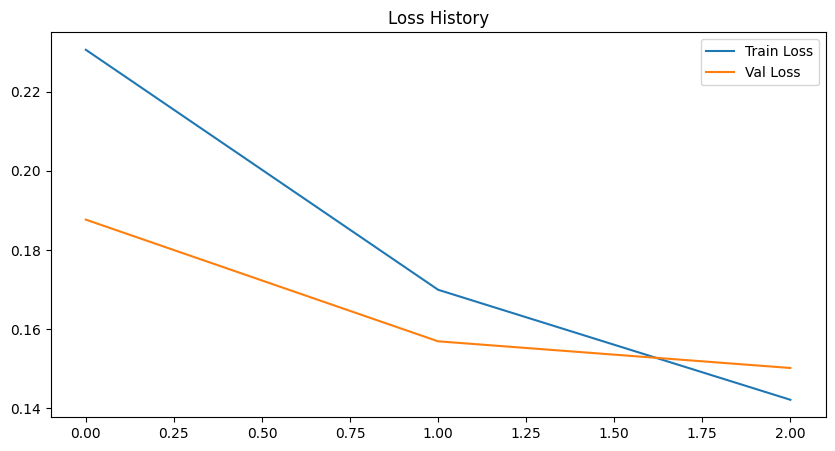

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Loss History")
plt.plot(result["train_loss_history"], label="Train Loss")
plt.plot(result["val_loss_history"], label="Val Loss")
plt.legend()
plt.show()

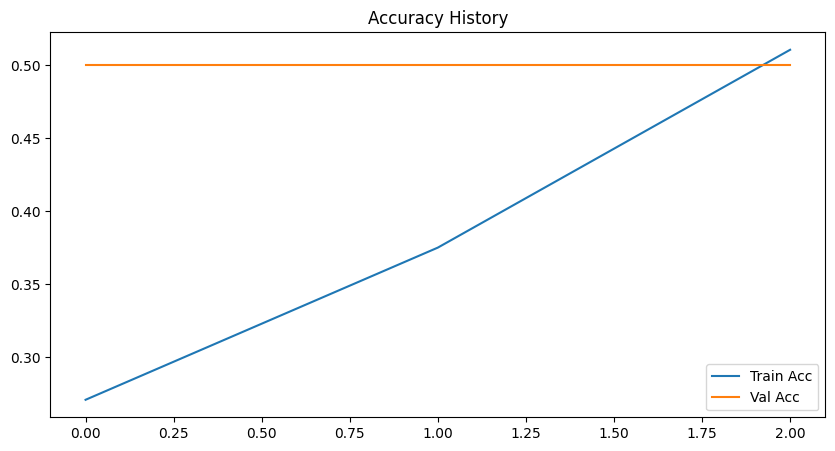

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Accuracy History")
plt.plot(result["train_acc_history"], label="Train Acc")
plt.plot(result["val_acc_history"], label="Val Acc")
plt.legend()
plt.show()

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(ground_truth, predictions)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()